In [1]:
from Medfl.LearningManager.utils import global_params

import sys
sys.path.append(global_params['base_url'])

import os
os.environ['PYTHONPATH'] = global_params['base_url']

In [2]:
import mysql.connector
import pandas as pd
from sqlalchemy import create_engine,text
import subprocess


# Torch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


## MedFL Imports 
## Network Manager Imports 
from Medfl.NetManager.node import Node
from Medfl.NetManager.network import Network
from Medfl.NetManager.dataset import DataSet
from Medfl.NetManager.flsetup import FLsetup

# flower imports 
import flwr as fl

## Learning Manager imports 
from Medfl.LearningManager.dynamicModal import DynamicModel
from Medfl.LearningManager.model import Model
from Medfl.LearningManager.strategy import Strategy
from Medfl.LearningManager.server import *
from Medfl.LearningManager.flpipeline import *
from Medfl.LearningManager.plot import AccuracyLossPlotter



# Utils
from Medfl.LearningManager.utils import *


2024-03-25 20:12:29.288774: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
class BinaryClassifier(nn.Module):
    def __init__(self, input_size, num_layers, layer_size):
        super(BinaryClassifier, self).__init__()

        # Input layer
        self.layers = [nn.Linear(input_size, layer_size)]
        
        # Hidden layers
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(layer_size, layer_size))
        
        # Output layer
        self.layers.append(nn.Linear(layer_size, 1))
        
        # ModuleList to handle dynamic number of layers
        self.layers = nn.ModuleList(self.layers)

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        x = self.layers[-1](x)
        return x

In [4]:
# Best HyperParams using optuna optimisation 
best_hyperparams = {'batch_size': 16, 'num_layers': 6, 'hidden_size': 46,
                    'optimizer': 'RMSprop', 'learning_rate': 0.0019940796634093597, 'num_epochs': 1}

In [5]:
#  Best threshold
best_th = 0.3

In [6]:
# The number of server rounds
n_rounds = [5 , 10,30]

In [7]:
benchmarks_config = {
    # * 1 . Differential Privacy
    # *******************************************
    "diff_privacy": [
        {
            # DP config
            "dp_activate": False,

            # The rest of the config
            "n_clients": 10,
            "train_test": True,
            "train_portion": 0.5,
            "aggreg_algo": "FedAvg",
            "Tl": True,
        },
        {
            # DP config
            "dp_activate": True,
            "DELTA": 1e-5,
            "EPSILON": 5.0,

            # The rest of the config
            "n_clients": 10,
            "train_test": True,
            "train_portion": 0.5,
            "aggreg_algo": "FedAvg",
            "Tl": True,
        },
        {
            # DP config
            "dp_activate": True,
            "DELTA": 1e-5,
            "EPSILON": 10.0,

            # The rest of the config
            "n_clients": 10,
            "train_test": True,
            "train_portion": 0.5,
            "aggreg_algo": "FedAvg",
            "Tl": True,
        },
        {
            # DP config
            "dp_activate": True,
            "DELTA": 1e-5,
            "EPSILON": 0.5,

            # The rest of the config
            "n_clients": 10,
            "train_test": True,
            "train_portion": 0.5,
            "aggreg_algo": "FedAvg",
            "Tl": True,
        },
        {
            # DP config
            "dp_activate": True,
            "DELTA": 1e-10,
            "EPSILON": 0.5,

            # The rest of the config
            "n_clients": 10,
            "train_test": True,
            "train_portion": 0.5,
            "aggreg_algo": "FedAvg",
            "Tl": True,
        }
    ],
    # * 2 . Nodes Config
    # *******************************************
    "nodes_config": [
        {
            # nodes config
            "train_test": True,
            "train_portion": 0.5,

            # The rest of the config
            "n_clients": 10,
            "dp_activate": False,
            "aggreg_algo": "FedAvg",
            "Tl": True,
        },
        {
            # nodes config
            "train_test": True,
            "train_portion": 0.7,

            # The rest of the config
            "n_clients": 10,
            "dp_activate": False,
            "aggreg_algo": "FedAvg",
            "Tl": True,
        },
        {
            # nodes config
            "train_test": False,
            "train_portion": 0.5,

            # The rest of the config
            "n_clients": 10,
            "dp_activate": False,
            "aggreg_algo": "FedAvg",
            "Tl": True,
        },
        {
            # nodes config
            "train_test": False,
            "train_portion": 0.7,

            # The rest of the config
            "n_clients": 10,
            "dp_activate": False,
            "aggreg_algo": "FedAvg",
            "Tl": True,
        },
    ],
    # * 3 . Aggregation Algorithm
    # *******************************************
    "Aggreg_algo": [
        {
            # Aggregation alrogithm
            "aggreg_algo": "FedAvg",

            # The rest of the config
            "train_test": True,
            "train_portion": 0.5,
            "n_clients": 10,
            "dp_activate": False,
            "Tl": True,
        },
        {
            # Aggregation alrogithm
            "aggreg_algo": "FedYogy",

            # The rest of the config
            "train_test": True,
            "train_portion": 0.5,
            "n_clients": 10,
            "dp_activate": False,
            "Tl": True,
        },
        {
            # Aggregation alrogithm
            "aggreg_algo": "FedAdaGrad",

            # The rest of the config
            "train_test": True,
            "train_portion": 0.5,
            "n_clients": 10,
            "dp_activate": False,
            "Tl": True,
        },
        {
            # Aggregation alro100githm
            "aggreg_algo": "FedAdam",

            # The rest of the config
            "train_test": True,
            "train_portion": 0.5,
            "n_clients": 10,
            "dp_activate": False,
            "Tl": True,
        },
    ],
    # * 4 . Aggregation Algorithm
    # *******************************************
    "n_clients": [
        {
            # Number of clients
            "n_clients": 5,

            # The rest of the config
            "train_test": True,
            "train_portion": 0.5,
            "aggreg_algo": "FedAvg",
            "dp_activate": False,
            "Tl": True,
        },
        {
            # Number of clients
            "n_clients": 10,

            # The rest of the config
            "train_test": True,
            "train_portion": 0.5,
            "aggreg_algo": "FedAvg",
            "dp_activate": False,
            "Tl": True,
        },
        {
            # Number of clients
            "n_clients": 30,

            # The rest of the config
            "train_test": True,
            "train_portion": 0.5,
            "aggreg_algo": "FedAvg",
            "dp_activate": False,
            "Tl": True,
        },

    ],
    # * 5 . Combine the configurations 
    # *******************************************
    "combined_config": []
}

In [8]:
# benchmarks_config = {
#     "diff_privacy" : [
#             {
#             # DP config
#             "dp_activate": True,
#             "DELTA": 1e-5,
#             "EPSILON": 5.0,

#             # The rest of the config
#             "n_clients": 10,
#             "train_test": True,
#             "train_portion": 0.5,
#             "aggreg_algo": "FedAvg",
#             "Tl": True,
#         },
#         {
#             # DP config
#             "dp_activate": False,

#             # The rest of the config
#             "n_clients": 10,
#             "train_test": True,
#             "train_portion": 0.5,
#             "aggreg_algo": "FedAvg",
#             "Tl": True,
#         }

#     ] , 
#     "n_clients": [
#         {
#             # Number of clients
#             "n_clients": 5,

#             # The rest of the config
#             "train_test": True,
#             "train_portion": 0.5,
#             "aggreg_algo": "FedAvg",
#             "dp_activate": False,
#             "Tl": True,
#         },
#         {
#             # Number of clients
#             "n_clients": 10,

#             # The rest of the config
#             "train_test": True,
#             "train_portion": 0.5,
#             "aggreg_algo": "FedAvg",
#             "dp_activate": False,
#             "Tl": True,
#         },
#     ],
# }

In [9]:
# Benchmarks_result stors the result of each configuration in the benchmark 
benchmarks_results = []

In [10]:
# a fuction to test if the config is already tested
def is_config_tested(config , n_rounds):
    for result in benchmarks_results:
        if result['config'] == config and n_rounds == result['n_rounds'] : return True
    
    return False 

In [11]:
device = torch.device(
            f"cuda" if torch.cuda.is_available() else "cpu"
        )

In [12]:

# Loop Over the benchmark configs
for key in benchmarks_config.keys():
    print("Executing the: " + key + " configurations")
    for config in benchmarks_config[key]:
        print("Executing th confuguration")
        print(config)
        for server_rounds in n_rounds:
            if(is_config_tested(config=config , n_rounds=server_rounds)):
                break
            # Create the MEDfl pipeline for each config

            # DB Creation
            subprocess.run(['python3', '../../scripts/create_db.py'])

            # Create a nest work "Net_1"
            Net_1 = Network(name="manual_network_2")
            Net_1.create_network()

            # Create a MasterDataSet from Net_1
            Net_1.create_master_dataset()

            # auto FLsetup creation
            autoFl = FLsetup(name="Flsetup_2",
                             description="The second fl setup", network=Net_1)
            autoFl.create()

            # Create Nodes
            if (config['train_test']):
                n_train = int(config['n_clients']*config['train_portion'])

                #  Create the Train nodes
                for i in range(1, 1 + n_train):
                    hospital = Node(name="hospital_"+str(i), train=1)
                    Net_1.add_node(hospital)
                    hospital.upload_dataset(
                        "hospital_"+str(i)+'_dataset', global_params['base_url'] + '/notebooks/data/nodesData/output_'+str(i)+'.csv')

                #  Create the test nodes
                for i in range(1 + n_train, config['n_clients'] + 1):
                    hospital = Node(name="hospital_"+str(40+i), train=0)
                    Net_1.add_node(hospital)
                    hospital.upload_dataset("hospital_"+str(40+i)+'_dataset',
                                            global_params['base_url'] + '/notebooks/data/nodesData/output_'+str(i)+'.csv')

                #  Create a test+train nodes
                else:
                    pass

            # Create FLDataSet
            fl_dataset = autoFl.create_federated_dataset(
                output="deceased",
                fit_encode=[],
                to_drop=["deceased"]
            )

            if (config['Tl']):
                # Load the pretrained model
                model = Model.load_model(
                    "../../notebooks/.ipynb_checkpoints/trainedModels/grid_search_classifier.pth")
            else:
                # Create the model with the suggested hyperparameters
                model = BinaryClassifier(input_size=fl_dataset.size,
                                         num_layers=best_hyperparams['num_layers'],
                                         layer_size=best_hyperparams['hidden_size'],)
                model.to(device)

            # Pass the specific_model to the Model class
            if best_hyperparams['optimizer'] == 'Adam':
                optimizer = optim.Adam(
                    model.parameters(), lr=best_hyperparams['learning_rate'])
            elif best_hyperparams['optimizer'] == 'SGD':
                optimizer = optim.SGD(model.parameters(),
                                      lr=best_hyperparams['learning_rate'])
            elif best_hyperparams['optimizer'] == 'RMSprop':
                optimizer = optim.RMSprop(
                    model.parameters(), lr=best_hyperparams['learning_rate'])

            # Define loss function and optimizer

            pos_weight = torch.tensor([(1 - best_th) / best_th])
            criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

            # Creating a new Model instance using the specific model created by DynamicModel
            global_model = Model(model, optimizer, criterion)

            # Get the initial params of the model
            init_params = global_model.get_parameters()

            # Create the strategy
            aggreg_algo = Strategy(config['aggreg_algo'],
                                   fraction_fit=1.0,
                                   fraction_evaluate=1.0,
                                   min_fit_clients=2,
                                   min_evaluate_clients=2,
                                   min_available_clients=2,
                                   initial_parameters=global_model.get_parameters())
            aggreg_algo.create_strategy()

            # Create The server
            server = FlowerServer(global_model,
                                  strategy=aggreg_algo,
                                  num_rounds=server_rounds,
                                  num_clients=len(fl_dataset.trainloaders),
                                  fed_dataset=fl_dataset,
                                  diff_privacy=config['dp_activate'],
                                  # You can change the resources alocated for each client based on your machine
                                  client_resources={
                                      'num_cpus': 1.0, 'num_gpus': 1.0}
                                  )
            # Create the pipeline
            ppl_1 = FLpipeline(name="the second fl_pipeline",
                               description="this is our first FL pipeline",
                               server=server)
            
            # Run the Traning of the model
            history = ppl_1.server.run()
            
            #  Print the results of the config 
            print('\n\n--------------------------------------------------- \n\n')
            print(config)
            print(server_rounds)
            print(server.auc[len(server.auc)-1])
            print('\n\n --------------------------------------------------- \n\n')
            
            # store the results 
            benchmarks_results.append({
                'n_rounds' : server_rounds,
                'config' : config , 
                'results' : server.auc[len(server.auc)-1]
            })


Executing the: diff_privacy configurations
Executing th confuguration
{'dp_activate': False, 'n_clients': 10, 'train_test': True, 'Train_portion': 0.5, 'aggreg_algo': 'FedAvg', 'Tl': True}


/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/pandas/io/sql.py:1761: RemovedIn20Warning: Deprecated API features detected! These feature(s) are not compatible with SQLAlchemy 2.0. To prevent incompatible upgrades prior to updating applications, ensure requirements files are pinned to "sqlalchemy<2.0". Set environment variable SQLALCHEMY_WARN_20=1 to show all deprecation warnings.  Set environment variable SQLALCHEMY_SILENCE_UBER_WARNING=1 to silence this message. (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  return insp.has_table(name, schema or self.meta.schema)


/home/local/USHERBROOKE/saho6810/MEDfl/code/MEDfl/notebooks/data/masterDataSet/Mimic_ouael.csv


KeyError: 'train_portion'

In [ ]:
print(benchmarks_results)

[{'n_rounds': 2, 'config': {'dp_activate': True, 'DELTA': 1e-05, 'EPSILON': 5.0, 'n_clients': 10, 'train_test': True, 'train_portion': 0.5, 'aggreg_algo': 'FedAvg', 'Tl': True}, 'results': 0.6242610837438424}, {'n_rounds': 3, 'config': {'dp_activate': True, 'DELTA': 1e-05, 'EPSILON': 5.0, 'n_clients': 10, 'train_test': True, 'train_portion': 0.5, 'aggreg_algo': 'FedAvg', 'Tl': True}, 'results': 0.5223280423280423}, {'n_rounds': 2, 'config': {'dp_activate': False, 'n_clients': 10, 'train_test': True, 'train_portion': 0.5, 'aggreg_algo': 'FedAvg', 'Tl': True}, 'results': 0.5546875}, {'n_rounds': 3, 'config': {'dp_activate': False, 'n_clients': 10, 'train_test': True, 'train_portion': 0.5, 'aggreg_algo': 'FedAvg', 'Tl': True}, 'results': 0.5477242664742665}, {'n_rounds': 2, 'config': {'n_clients': 5, 'train_test': True, 'train_portion': 0.5, 'aggreg_algo': 'FedAvg', 'dp_activate': False, 'Tl': True}, 'results': 0.5772771672771673}, {'n_rounds': 3, 'config': {'n_clients': 5, 'train_test': 

In [ ]:
def get_results_by_categ(benchmarks_results , categ):
    results = []
    try:
        for res in benchmarks_results:
            if(res['config'] in benchmarks_config[categ]):
                results.append(res)
        return results
    except:
        print(" Category not found in the benchmarking results")
        return []

    

In [ ]:
import matplotlib.pyplot as plt

def plot_benchmarks_results(benchmarks_results , categ):
  

    # Sample data
    data = get_results_by_categ(benchmarks_results=benchmarks_results , categ=categ) 

    if(data and len(data)!= 0):
        # Group data by 'config' for separate graphs
        config_groups = {}
        for entry in data:
            config = tuple(entry['config'].items())  # Convert dictionary to tuple
            if config not in config_groups:
                config_groups[config] = {'n_rounds': [], 'results': []}
            config_groups[config]['results'].append(entry['results'])
            config_groups[config]['n_rounds'].append(entry['n_rounds'])
        

        # Plotting
        for config, values in config_groups.items():
            plt.plot(values['n_rounds'],values['results'],  label=dict(config))

        # Set labels and legend
        plt.xlabel('n_rounds')
        plt.ylabel('results')
        plt.legend()

        # Show plot
        plt.show()
    return 

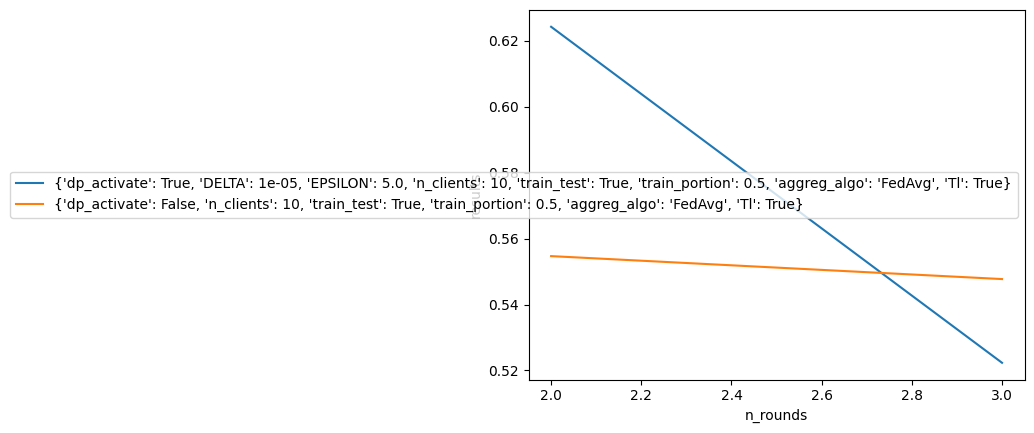

In [ ]:
plot_benchmarks_results(benchmarks_results=benchmarks_results , categ="diff_privacy" )

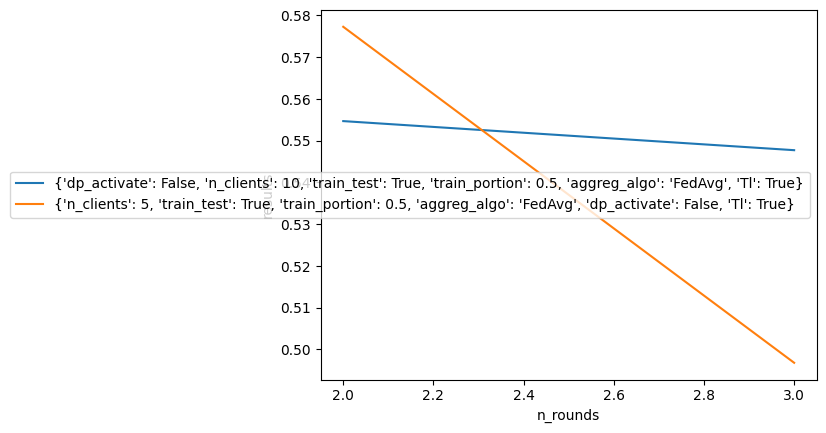

In [ ]:
plot_benchmarks_results(benchmarks_results=benchmarks_results , categ="n_clients" )

## Plot the results 

### 1. Differential Privacy
